# Klasyfikacja Gatunków Pingwinów za Pomocą Modelu SVC

Ten notatnik zawiera kompletny proces uczenia maszynowego: od analizy eksploracyjnej danych (EDA), przez ich przygotowanie, aż po trenowanie i ocenę modelu klasyfikacyjnego.

**Cel:** Zbudowanie modelu, który na podstawie cech fizycznych pingwina (takich jak wymiary dzioba i płetwy) będzie w stanie poprawnie zidentyfikować jego gatunek.

**Zbiór danych:**  `Palmer Penguins`, który zawiera dane dla trzech gatunków pingwinów: Adelie, Chinstrap i Gentoo.

**Model:** Klasyfikator wektorów nośnych (Support Vector Classifier - SVC)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:

penguin_df = pd.read_csv('../data/penguins.csv')

## 1. Analiza Eksploracyjna Danych (EDA)

Celem tej sekcji jest zrozumienie charakterystyki zbioru danych, w tym rozkładu poszczególnych zmiennych, identyfikacja wartości brakujących oraz analiza wzajemnych relacji.

In [3]:
print("Pierwsze 5 wierszy danych:")
penguin_df.head(5)

Pierwsze 5 wierszy danych:


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
print("\nInformacje o typach danych i brakujących wartościach:")
penguin_df.info()


Informacje o typach danych i brakujących wartościach:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [15]:
print("\nStatystyki opisowe:")
penguin_df.describe(include='all')


Statystyki opisowe:


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [16]:
print("\nKorelacja między cechami numerycznymi")
penguin_df.corr(numeric_only = True)


Korelacja między cechami numerycznymi


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.235053,0.656181,0.595110
culmen_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


In [17]:
print("\nBrakujące wartości:")
penguin_df.isnull().sum()


Brakujące wartości:


species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [18]:
print("\n Liczeność ze względu na płeć:")
penguin_df.sex.value_counts()


 Liczeność ze względu na płeć:


sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

In [19]:
penguin_df[penguin_df["sex"]=='.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


### Wizualizacje

In [20]:
print("\nLiczebność gatunków")
penguin_df['species'].value_counts()


Liczebność gatunków


species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

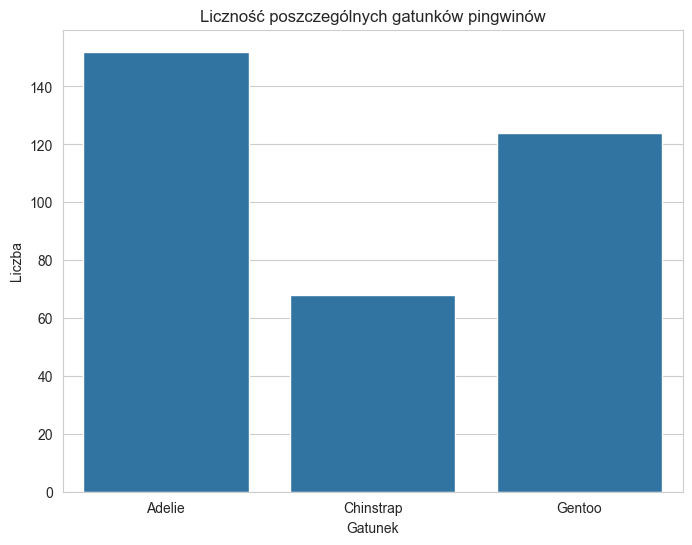

In [21]:
# Rozkład liczności gatunków
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=penguin_df, x='species')
plt.title('Liczność poszczególnych gatunków pingwinów')
plt.xlabel('Gatunek')
plt.ylabel('Liczba')
plt.show()

Analiza zależności między cechami numerycznymi:


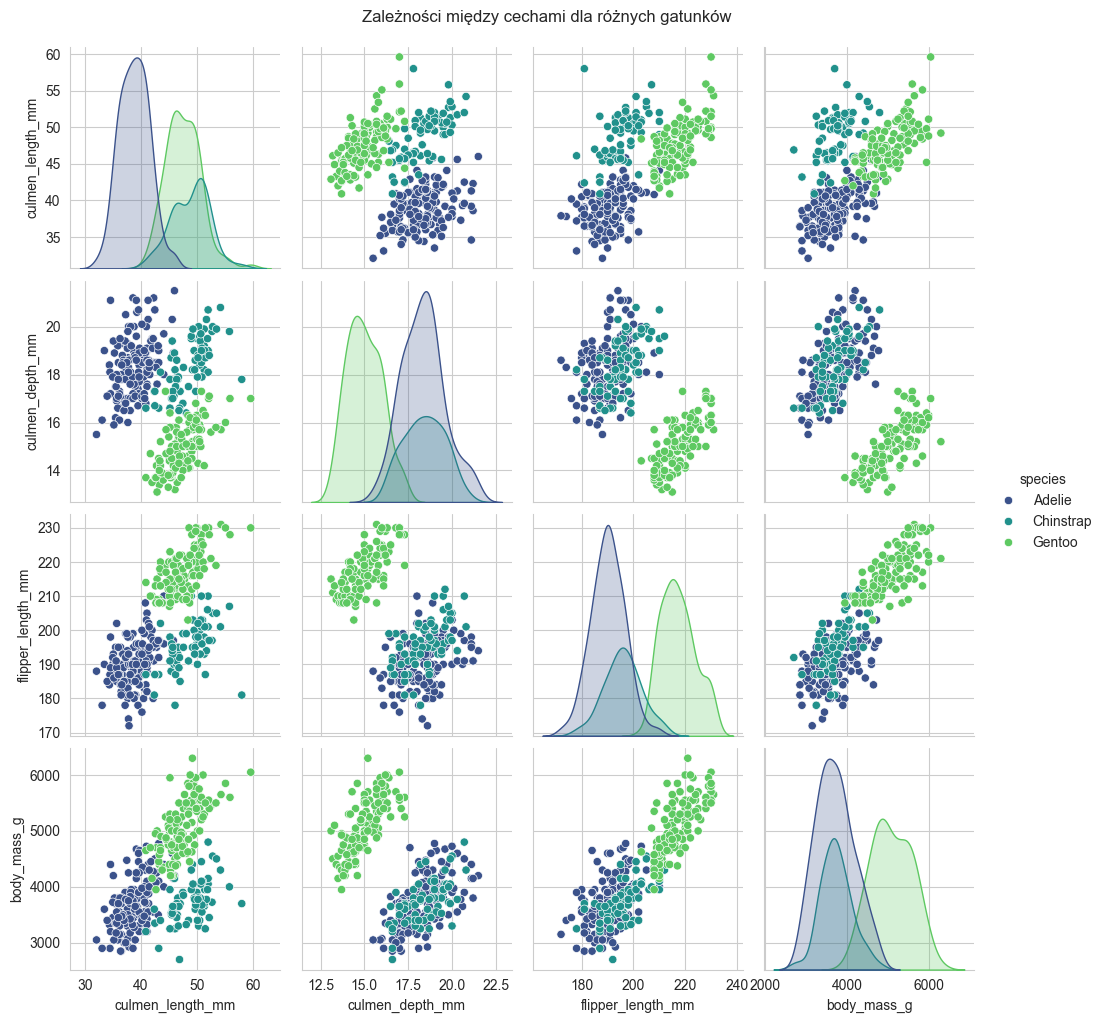

In [22]:
# Wykres par (pairplot) do analizy zależności między cechami
# Zobaczymy, jak cechy różnią się w zależności od gatunku.
print("Analiza zależności między cechami numerycznymi:")
sns.pairplot(penguin_df.dropna(), hue='species', palette='viridis')
plt.suptitle('Zależności między cechami dla różnych gatunków', y=1.02)
plt.show()

### Wnioski z EDA 
- Brakujące dane: zidentyfikowano niewielką liczbę brakujących wartości. Można je usunąć z analizy lub uzupełnić np. za pomocą średniej wartości dla danej cechy 
- Niezbalansowanie klas: Zbiór danych jest niezbalansowany, co oznacza, że poszczególne klasy (gatunki) nie są reprezentowane przez jednakową liczbę obserwacji. Ze względu na ograniczony rozmiar całego zbioru danych, zastosowanie technik balansowania (takich jak oversampling czy undersampling) mogłoby prowadzić do nadmiernego dopasowania modelu (overfittingu), dlatego na tym etapie zrezygnowano z ich użycia.
- Z `pairplot` widać, że gatunki tworzą dość wyraźne klastry. Na przykład pingwiny Gentoo mają znacznie dłuższe płetwy i większą masę ciała. 

## 2. Przygotowanie Danych

Krok czyszczenia danych jest arbitralny. Ponizszy krok imputacji jest przykładem braku powtarzalności. Jeśli w przyszłości otrzymamy nowe dane, będziemy musieli pamiętać, aby zastosować dokładnie tę samą logikę. Ale jeśli zdecydujemy się na inną strategię, np. usunięcie tych obserwacji? Manualna zmiana w notatniku jest prosta, ale prowadzi do niespójności. 
Zautomatyzowany komponent w potoku MLOps zapewniłby, że ta sama transformacja jest stosowana za każdym razem.


In [23]:
# Uzupełnienie brakujących danych

# Zastąpienie wartości '.' w kolumnie sex
penguin_df.loc[336,'sex'] = 'FEMALE'
df_clean = penguin_df.copy()
numerical_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
df_clean['sex'] = df_clean['sex'].fillna(df_clean['sex'].mode()[0])

df_clean.isnull().sum()


species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [24]:
df_clean.sex.value_counts()

sex
MALE      178
FEMALE    166
Name: count, dtype: int64

#### Kodowanie cech kategorycznych 

In [25]:
df_clean['sex'] = df_clean['sex'].map({'MALE': 0, 'FEMALE': 1})
df_processed = pd.get_dummies(df_clean, columns=['island'], drop_first=True)

Zdefiniowanie cech (X) i etykiety (y)

In [26]:
X = df_processed.drop('species', axis=1)
y = df_processed['species']

Podział na zbiór treningowy i testowy

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Parametry takie jak `test_size=0.3` i `random_state=42` są tutaj bezpośrednio wpisane. Utrudnia to łatwe eksperymentowanie i sprawdzanie wpływu tych parametrów na wynik bez modyfikacji kodu. 
W systemach produkcyjnych  wartości tych zmiennych byłby parametrami konfiguracyjnymi potoku.

In [28]:
print(f"\nRozmiar zbioru treningowego: {X_train.shape[0]} ")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} ")


Rozmiar zbioru treningowego: 240 
Rozmiar zbioru testowego: 104 


## 3. Trenowanie Modelu SVC


In [29]:
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True, random_state=42))
])

# Trenowanie modelu
svc_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'


Dokładność modelu (Accuracy): 0.9808
Raport klasyfikacji: 
              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        46
   Chinstrap       0.95      1.00      0.98        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Macierz pomyłek:


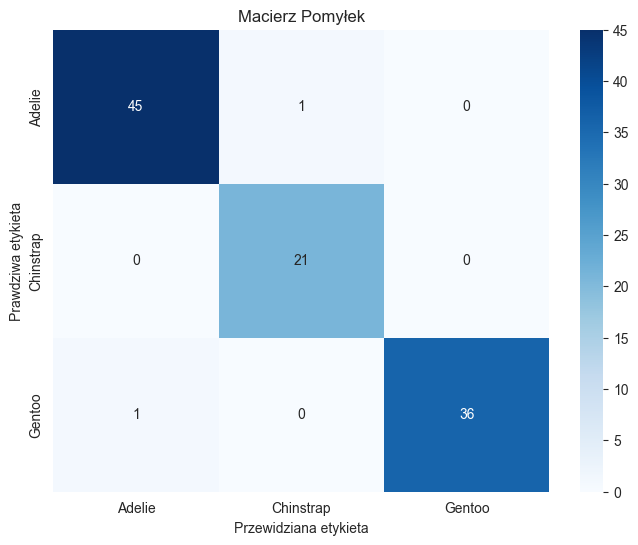

In [30]:
y_pred = svc_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność modelu (Accuracy): {accuracy:.4f}")

print("Raport klasyfikacji: ")
print(classification_report(y_test, y_pred))

print("Macierz pomyłek:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc_pipeline.classes_, yticklabels=svc_pipeline.classes_)
plt.title('Macierz Pomyłek')
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Prawdziwa etykieta')
plt.show()

In [31]:
MODEL_PATH=BUCKET_NAME+"/models/"
model_path = "./" + "model.pkl"
with open(model_path, 'wb') as file:  
    pickle.dump(model, file)

#copy model artifacts to GCS storage
!gsutil cp "model.pkl" $MODEL_PATH

['penguin_svc_model.pkl']

In [32]:

serving_container_uri = "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-3:latest"


artifact_uri = MODEL_PATH

#Upload Model to Vertex AI Model Registry using Python SDK
model = aiplatform.Model.upload(display_name= "MLOps0-model" ,
                                    artifact_uri=artifact_uri,
                                    serving_container_image_uri=serving_container_uri)

['model.joblib']

In [33]:
#Create the model endpoint using Python SDK
endpoint = model.deploy(machine_type="n1-standard-4",
                        min_replica_count=1,
                        max_replica_count=1)

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('svc', SVC(kernel='linear', probability=True, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'svc': SVC(kernel='linear', probability=True, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': 42,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [38]:
instances = [
    [1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24, 0.2879, 0.81, 0.0, 3.0, 13.0],
  ]

prediction = endpoint.predict(instances=instances)

print(prediction)

✅ Model oczekuje 7 następujących cech:
['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'island_Dream', 'island_Torgersen']
